In [1]:
# Libraries import 

import matplotlib.pyplot as plt
import numpy as np
from utilities import create_main_dataframe
from scipy.stats import normaltest
from scipy.signal import welch


In [2]:
# Function definition

def normal_d_test(rnd_var):
    _, p_val = normaltest(rnd_var)
    return p_val

In [3]:
# Load and prepare the data

task1_path = ".\\task_1_noise_analysis"
main_frame = create_main_dataframe(task1_path)
main_frame.sort_values(by=["ChNum", "MeasureNum"])
main_frame["Current"] = main_frame["Current"] * 1e6 # Current in the files is given in uA. To convert to pA values are multiplied by 1e6


TASK 1. Visualize the noise data for each channel.

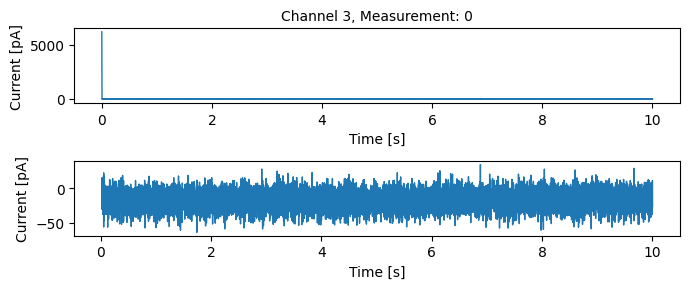

In [4]:
# Plot single measurement

channel_number = 3 # Choose sensor/channel
measurement_number = 0 # Choose measurement

single_measurement = main_frame[
    (main_frame["ChNum"] == 2) &
    (main_frame["MeasureNum"] == 2)
].copy().reset_index()

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 3))
x = single_measurement["Time"]
y = single_measurement["Current"]
ax[0].plot(x, y, linewidth=1)
ax[0].set_ylabel("Current [pA]")
ax[0].set_title(f"Channel {channel_number}, Measurement: {measurement_number}", fontsize=10)
ax[0].set_xlabel("Time [s]")

ax[1].plot(x.iloc[50:], y.iloc[50:], linewidth=1)
ax[1].set_ylabel("Current [pA]")
ax[1].set_xlabel("Time [s]")

fig.tight_layout()

In [5]:
# Group the data for further use

cut_idx = 50 # Take only the steady state portion of the Current
main_frame = main_frame.drop(main_frame.index[:cut_idx]).reset_index(drop=True)
channel_groups = main_frame.groupby(["ChNum"]) # Grouping by sensor
channel_measurement_groups = main_frame.groupby(["ChNum", "MeasureNum"]) # Grouping by Sensor and Measurement Number

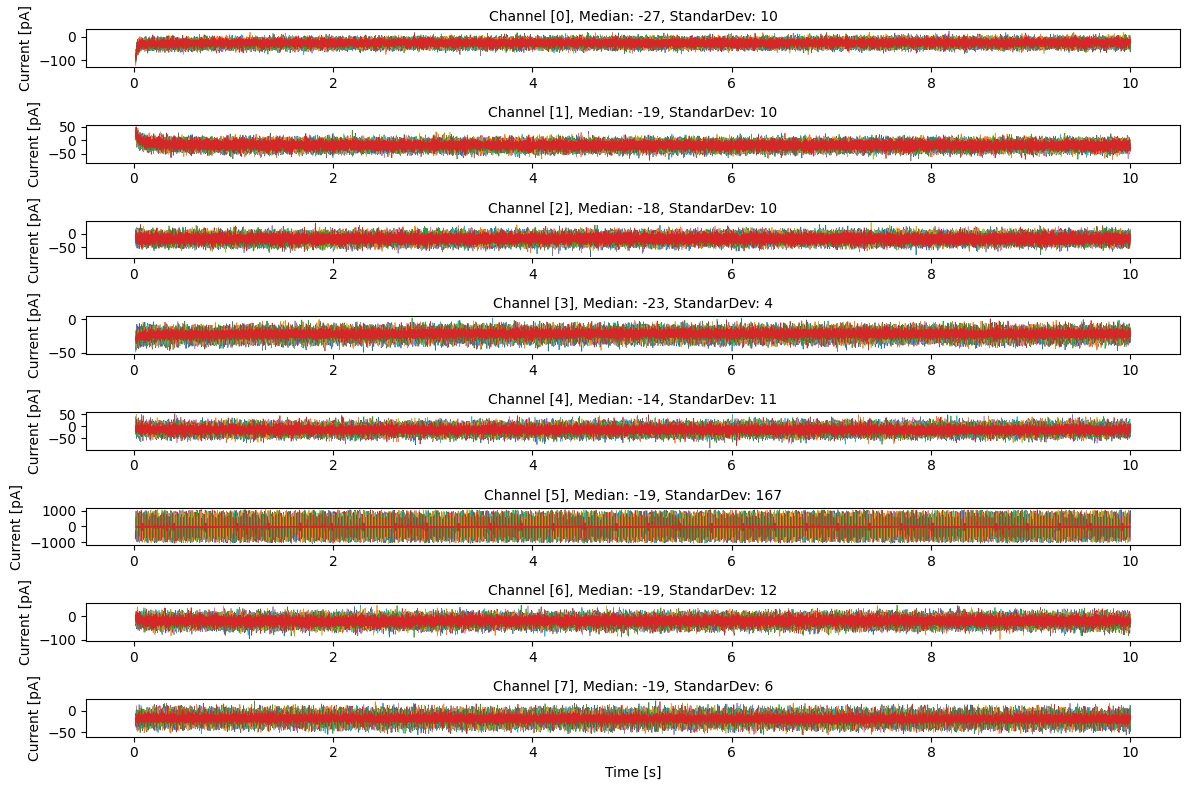

In [6]:
# Plot all measurements grouped per channel/sensor

fig0, ax0 = plt.subplots(nrows=8, ncols=1, figsize=(12, 8))
for row, (_, group) in enumerate(channel_groups):
    ch_num = group["ChNum"].unique()
    median = group["Current"].median()
    std = group["Current"].std()
    for i in range(group["MeasureNum"].max()):
        single_measurement = group[group["MeasureNum"] == i]
        x = single_measurement["Time"]
        y = single_measurement["Current"]
        ax0[row].plot(x, y, linewidth=0.5)
        ax0[row].set_ylabel("Current [pA]")
    ax0[row].set_title(f"Channel {ch_num}, Median: {round(median)}, StandarDev: {round(std)}", fontsize=10)
ax0[-1].set_xlabel("Time [s]")
fig0.tight_layout()


TASK 2. Perform noise analysis and provide a brief description of your approach.

The noise is evaluated using:

1. Standard Statistical Parameters & Methods:
    Parameters: Median, Standard Deviation
    Methods: D'Agostino-Pearson test for normality
2. Power Spectral Density (PSD)

Findings from Standard Statistical Analysis:
    1. All sensor measurements exhibit similar Medians, Means, and Standard Deviations.
    2. Ensemble Medians, calculated across all measurements within each sensor, differ by only a few pA between channels/sensors.
    3. Ensemble Standard Deviations show greater variability compared to Medians.
    4. One sensor (Channel 5) exhibits a significantly high Ensemble Standard Deviation.
    5. The noise distribution is not normal, as indicated by extremely small p-values in the D'Agostino-Pearson test for both individual measurements and ensemble evaluations.

Findings from PSD Analysis:
    1. Sensors labeled as Channels 0, 1, and 2 exhibit similar noise power.
    2. A peak at approximately 50 Hz is present in most sensors, except for Channels 4 and 5.


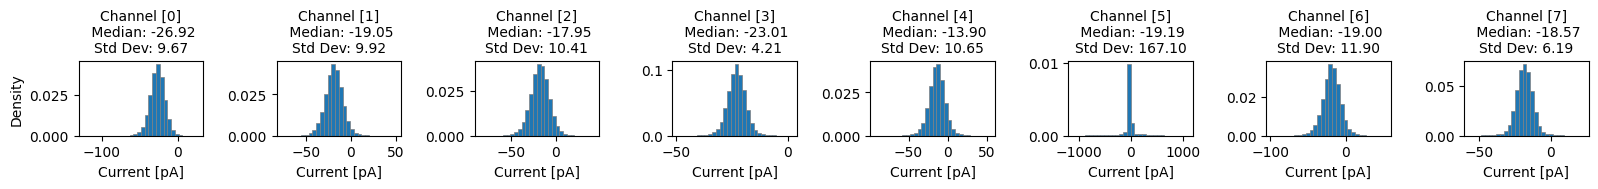

In [7]:
# Plot histograms of the current for each channel across all measurements (per ensemble)

fig1, ax1 = plt.subplots(nrows=1, ncols=8, figsize=(16, 2))
for row, (_, group) in enumerate(channel_groups):
    ch_num = group["ChNum"].unique()
    median = group["Current"].median()
    std = group["Current"].std()
    y = group["Current"]
    ax1[row].hist(y, bins=30, edgecolor="gray", linewidth=0.5, density=True)

    ax1[row].set_title(f"Channel {ch_num}\n Median: {median:.2f}\nStd Dev: {std:.2f}", fontsize=10)
    ax1[row].set_xlabel("Current [pA]")

ax1[0].set_ylabel("Density")
fig1.tight_layout()

In [8]:
# Compute and display stat parameters (Median, Standard Dveiation, Mean, and D'Agostino - Pearson p value) for all channels and all measurements.

stats = channel_measurement_groups["Current"].agg(
    median='median',
    std='std',
    normal_p_val=normal_d_test,
    mean='mean'
).reset_index()

print(stats)
num_norm = (stats["normal_p_val"] > 0.05).sum()
print(f"Number of channels which passed D'Agostino - Pearson normal test: {num_norm}")

     ChNum  MeasureNum     median       std   normal_p_val       mean
0        0           0 -31.161429  9.385129  5.632033e-146 -31.258631
1        0           1 -28.014291  9.580168  1.783468e-107 -28.156844
2        0           2 -27.585137  9.605922  3.772137e-112 -27.783541
3        0           3 -27.108298  9.554759  3.269594e-153 -27.240737
4        0           4 -27.012929  9.586241  7.095775e-100 -27.143790
..     ...         ...        ...       ...            ...        ...
115      7          10 -18.477512  6.197192  2.467822e-311 -18.599231
116      7          11 -18.572879  6.148670   0.000000e+00 -18.620607
117      7          12 -18.429828  6.153085   0.000000e+00 -18.478335
118      7          13 -18.620563  6.209011  8.328727e-308 -18.615181
119      7          14 -18.429828  6.162627   0.000000e+00 -18.456682

[120 rows x 6 columns]
Number of channels which passed D'Agostino - Pearson normal test: 0


In [9]:
# Compute Current PSD using Welch for every measurement, and then average per channel/sensor

ch_psd_channels = dict()
frequencies = np.array([])
for _, chg in channel_groups:
    channel_im_groups = chg.groupby("MeasureNum")
    ch_psd_arr=[]
    ch_num = chg["ChNum"].iloc[0]
    for _, chimg in channel_im_groups:
        dt = chimg["Time"].diff().mean()
        f = 1 / dt
        frequencies, ch_psd = welch(chimg["Current"], fs=f, nperseg=256)

        # print(normaltest(chimg["Current"])) # Uncomment this line to get the normal test for each measurement

        ch_psd_arr.append(ch_psd)
    ch_psd_channels[ch_num] = np.mean(ch_psd_arr, axis=0)

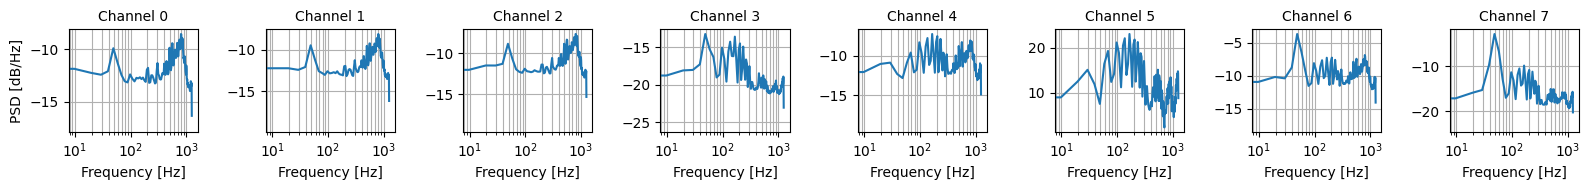

In [10]:
# Plot of the per channel/sensor average PSD

fig2, ax2 = plt.subplots(nrows=1, ncols=8, figsize=(16, 2))
for key, val in ch_psd_channels.items():
    psd = val
    ax2[key].semilogx(frequencies, 10 * np.log10(psd), label=f'Channel {key}')
    ax2[key].set_title(f"Channel {key}", fontsize=10)
    ax2[key].set_xlabel("Frequency [Hz]")
    ax2[key].grid(which='both')

ax2[0].set_ylabel("PSD [dB/Hz]")
fig2.tight_layout()

TASK 3. Identify, quantify and visualize any corrupted channels.

Based on the visual inspection of the measurements for individual sensors, 
along with the analysis of statistical parameters—especially the standard deviation per ensemble—the corrupted sensor is identified as channel 5. 
This channel exhibits the highest current oscillations and the largest standard deviation. 

In [11]:
# Prepare for the next plot

categories = stats["ChNum"].unique()
num_categories = len(categories)
colormap = plt.colormaps['tab10']
category_colors = {category: colormap(i / num_categories) for i, category in enumerate(categories)}
stats["Color"] = stats["ChNum"].map(category_colors)

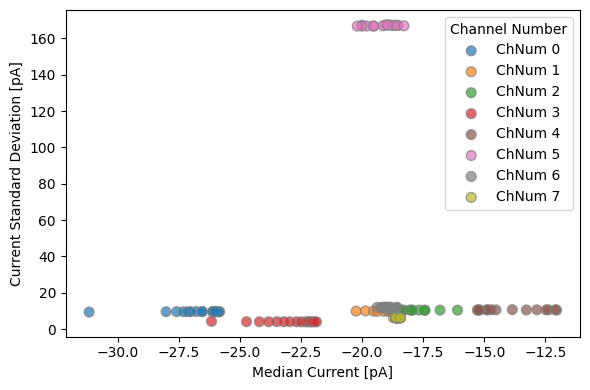

In [12]:
# Plot of the standard deviation versus median to identify corrupted channels/sensors. 
# Colors represent individual sensors, and each marker corresponds to a parameter computed from a single measurement.

fig3, ax3 = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
for category in categories:
    category_data = stats[stats["ChNum"] == category]
    ax3.scatter(category_data["median"], category_data["std"],
                c=category_data["Color"], label=f"ChNum {category}", s=50, edgecolors="gray", alpha=0.7)
ax3.legend(title="Channel Number")
ax3.set_xlabel("Median Current [pA]")
ax3.set_ylabel("Current Standard Deviation [pA]")
fig3.tight_layout()